Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Imports

In [ ]:
## General
import time
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, pmap
import functools
from jax import random
import matplotlib.pyplot as plt

import pickle
import tempfile

#from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

## Data Pipeline
import os
from dataclasses import dataclass
import tensorflow as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_text as tftxt

## Brain
from flax import linen as nn

## Training Loop
import optax
from flax.training import train_state
from flax import jax_utils

In [ ]:
## Test TPUs
print(f'Found {jax.device_count()} devices')
#jax.devices()

Found 8 devices


# Data Pipeline

## Tokenization

In [ ]:
def generate_vocab(ds_name, vocab_args, ds_split='train', text_feat='text', bs=1000, pref=2):
  ds_builder = tfds.builder(ds_name)
  ds = ds_builder.as_dataset(split = ds_split)
  vocab = bert_vocab.bert_vocab_from_dataset(
      ds.map(lambda dic : dic[text_feat]).batch(bs).prefetch(pref),
      **vocab_args
  )
  return vocab

In [ ]:
def get_tokenizer_from_vocab_file(file_id, bert_tokenizer_params):
  target_filename = 'vocab.txt'
  load_vocab = load_file(file_id)
  with open(target_filename, 'w') as f:
    for token in load_vocab:
      print(token, file=f)
  
  return tftxt.BertTokenizer(target_filename, **bert_tokenizer_params)

## Build Datasets

In [ ]:
@dataclass
class Tokenize:
  tokenizer: tftxt.BertTokenizer
  name: str = "text"
  def __call__(self, features):
    return {
        k: self.tokenizer.tokenize(v) if k == self.name else v
        for k, v in features.items()
    }

@dataclass
class FlattenWordDim:
  name: str = 'text'
  def __call__(self, features):
    return {
        k: v.merge_dims(-2,-1) if k == self.name else v
        for k, v in features.items()
    }

@dataclass
class FixedSeqLen:
  seq_len: int
  name: str = 'text'
  def __call__(self, features):
    return {
        k: v.to_tensor(shape=[None, self.seq_len]) if k == self.name else v
        for k, v in features.items()
    }

@dataclass
class DevSplit:
  num_dev: int
  seq_len: int
  name: str = 'text'
  def __call__(self, features):
    return {
        k: tf.reshape(v, [num_dev, -1, seq_len]) if k == self.name else v
        for k, v in features.items()
    }

In [ ]:
def get_preprocess_fn(tokenizer, seq_len, num_dev):
  return preprocess_spec.PreprocessFn([
    Tokenize(tokenizer), FlattenWordDim(), FixedSeqLen(seq_len), DevSplit(num_dev, seq_len)],
    only_jax_types=False)

In [ ]:
def get_datasets(cfg, tokenizer):
  """ cfg: dict contains:
    name: dataset name
    batch_size
    seq_len: number of tokens per sequence
    shuffle_buffer: fills a buffer with this many elements, than samples from it (replacing sampled elements with new elements)
    prefetch_size: prefetches this many batches
  """
  ds_builder = tfds.builder(cfg['name'])
  preprocess_fn = get_preprocess_fn(tokenizer, cfg['seq_len'], cfg['num_dev'])
  def raw_data(split, shuffle):
    #per_host_split = deterministic_data.get_read_instruction_for_host(split, ds_builder.info.splits[split].num_examples)
    ds = ds_builder.as_dataset(split=split)
    if shuffle:
      ds = ds.shuffle(cfg['shuffle_buffer'])
    ds = ds.batch(cfg['batch_size'], drop_remainder=True, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(cfg['prefetch_size'])
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()

    return tfds.as_numpy(ds)

  train_ds = raw_data("train", True)
  test_ds = raw_data("test", False)
  return train_ds, test_ds

# Brain

In [ ]:
#@functools.partial(jit, static_argnums=(1,2))
def mps_norm_sq(params, n_cores, partial_len):
  """
  Cores have shape (vocab, bond_dim**2),
  except first/last, which have shape (vocab, bond_dim)
  """
  vocab, bond_dim = params['core_0']['embedding'].shape
  top_list = [params[f'core_{i}']['embedding'] for i in range(n_cores)]
  bot_list = top_list.copy()

  Tcore = top_list.pop(0)
  Bcore = bot_list.pop(0)
  cap = jnp.matmul(Bcore.T, Tcore).reshape(1, bond_dim, bond_dim)
  log_norm = 0.0

  for i in range(n_cores-2):
    Tcore = jnp.matmul(cap, top_list.pop(0).reshape(vocab, bond_dim, bond_dim)).reshape(-1, bond_dim)
    Bcore = bot_list.pop(0).reshape(-1, bond_dim)
    cap = jnp.matmul(Bcore.T, Tcore).reshape(1, bond_dim, bond_dim)
    #if i % partial_len == 0:
    cap_norm = jnp.linalg.norm(cap)
    log_norm += jnp.log(cap_norm)
    cap = cap/cap_norm

  Tcore = jnp.matmul(top_list.pop(0), cap.transpose(0,2,1)).reshape(-1)
  Bcore = bot_list.pop(0).reshape(-1)
  log_norm += jnp.log(jnp.matmul(Bcore, Tcore))

  return log_norm

In [ ]:
## Modified "variance_scaling" function from Jax
def unit_embed_init(key, shape, dtype=jnp.float_):
  tot_shape = 1
  for s in shape: tot_shape *= s
  fan_in = tot_shape / shape[-1]
  variance = jnp.array(1.0 / fan_in, dtype=dtype)

  embeds = random.normal(key, shape, dtype) #* jnp.sqrt(variance)
  norms = jnp.linalg.norm(embeds, axis = -1)

  return embeds / norms[:,None]

def iden_embed_init(key, shape, dtype=jnp.float_):
  vocab_sqrt = np.sqrt(shape[0])
  bond_dim = np.sqrt(shape[1]).astype(int)

  base = np.identity(bond_dim).flatten() / vocab_sqrt
  embeds = random.normal(key, shape, dtype) * 1E-4
  return embeds + base

def orth_init(key, shape, dtype=jnp.float_):
  bond_dim = np.sqrt(shape[1]).astype(int)
  slice_list = []
  for slice in range(shape[0]):
    key, slice_key = jax.random.split(key)
    rand = random.normal(slice_key, (bond_dim, bond_dim), dtype)
    q,_ = jnp.linalg.qr(rand)
    slice_list.append(q.flatten())
  return jnp.stack(slice_list)

def rand_init(key, shape, dtype=jnp.float_):
  return random.normal(key, shape, dtype) * 0.5

In [ ]:
class MPS(nn.Module):
  ## Assume fixed length input sequences
  num_cores: int
  bond_dim: int
  vocab_size: int
  embed_dtype: jnp.dtype

  def setup(self):
    init = rand_init
    self.left_core = nn.Embed(self.vocab_size, self.bond_dim, name="core_0", embedding_init=init, dtype=self.embed_dtype)
    self.mid_core_list = [nn.Embed(self.vocab_size, self.bond_dim**2, name=f'core_{i+1}', embedding_init=orth_init, dtype=self.embed_dtype) for i in range(self.num_cores-2)]
    self.right_core = nn.Embed(self.vocab_size, self.bond_dim, name=f"core_{self.num_cores-1}", embedding_init=init, dtype=self.embed_dtype)

  def __call__(self, x, partial_len):
    assert x.shape[-1] == len(self.mid_core_list) + 2

    contr_cores = [self.left_core(x[:,0]).reshape(-1, 1, self.bond_dim)]
    contr_cores += [core(x[:,i+1]).reshape(-1, self.bond_dim, self.bond_dim) for i, core in enumerate(self.mid_core_list)]
    contr_cores += [self.right_core(x[:,-1]).reshape(-1, self.bond_dim, 1)]

    log_scalar = jnp.zeros(x.shape[0], dtype=self.embed_dtype)
    while len(contr_cores) > 1:
      ## do partial_len contractions, then add the partial result to the log_scalar
      contr_len = min(partial_len, len(contr_cores)-1)
      for i in range(contr_len):
        Lcore = contr_cores.pop(0)
        contr_cores[0] = jnp.matmul(Lcore, contr_cores[0])
      norm = jnp.linalg.norm(contr_cores[0], axis=-1)
      log_scalar += jnp.log(norm).flatten()
      contr_cores[0] = contr_cores[0] / norm[:,None]
    
    return log_scalar

# Training & Validation

In [ ]:
def loss_fn(log_outputs, log_norm_sq, alpha):
  return -jnp.mean( log_outputs - 0.5*log_norm_sq ) + alpha * log_norm_sq

def compute_metrics(sync_loss, sync_LNS, alpha):
  metric_loss = jax_utils.unreplicate(sync_loss)
  metric_LNS = jax_utils.unreplicate(sync_LNS)
  return {
      'loss' : metric_loss,
      'pred_loss' : metric_loss - alpha*metric_LNS,
      'log_norm_sq' : metric_LNS
  }

In [ ]:
## Training Loop
## N.B. pmap automatically jits its argument
@functools.partial(pmap, axis_name='num_devices', static_broadcasted_argnums=(2,3))
def train_step(state, batch, alpha, partial_len):
  """Train for a single step."""
  def train_loss(params):
    log_outputs = state.apply_fn({'params': params}, batch, partial_len)
    log_norm_sq = mps_norm_sq(params, batch.shape[-1], partial_len)
    loss = loss_fn(log_outputs, log_norm_sq, alpha)
    return loss, log_norm_sq
  grad_fn = jax.value_and_grad(train_loss, has_aux=True)
  (p_loss, p_log_norm_sq), p_grads = grad_fn(state.params)

  sync_grads = jax.lax.pmean(p_grads, axis_name='num_devices')
  sync_loss = jax.lax.pmean(p_loss, axis_name='num_devices')

  state = state.apply_gradients(grads=sync_grads)
  """
  N.B. pmean syncs over devices, so we can just take the first element,
  which will be the same on each device in the ShardedDeviceArray
  """
  return state, sync_loss, p_log_norm_sq


def train_epoch(state, train_ds, alpha, partial_len, rng):
  """Train for a single epoch."""
  batch_metrics = []
  #i = 0
  for feat_batch in train_ds:
    state, sync_loss, sync_LNS = train_step(state, feat_batch['text'], alpha, partial_len)
    metrics = compute_metrics(sync_loss, sync_LNS, alpha)
    '''
    print(f"step {i :02}")
    for k,v in metrics.items():
      print(f"\t{k}: {v}")
    i+=1
    #'''
    batch_metrics.append(metrics)

    loss = metrics['loss']
    if np.isnan(loss) or np.isinf(loss):
      break

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  return state, epoch_metrics_np

In [ ]:
## Validation Loop
@functools.partial(pmap, axis_name='num_devices', static_broadcasted_argnums=(3,4))
def eval_step(state, batch, log_norm_sq, alpha, partial_len):
  log_outputs = state.apply_fn({'params': state.params}, batch, partial_len)
  p_loss = loss_fn(log_outputs, log_norm_sq, alpha)
  return jax.lax.pmean(p_loss, axis_name='num_devices')


def eval_model(state, test_ds, seq_len, alpha, partial_len):
  log_norm_sq = jax_utils.replicate(mps_norm_sq(jax_utils.unreplicate(state.params), seq_len, partial_len))
  
  batch_metrics = []
  for feat_batch in test_ds:
    sync_loss = eval_step(state, feat_batch['text'], log_norm_sq, alpha, partial_len)
    metrics = compute_metrics(sync_loss, log_norm_sq, alpha)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  return epoch_metrics_np

# Parameter Optimization

In [ ]:
def warmup_constant_schedule(init_value=0.0001, end_value=0.01, warmup_steps=25000*10):
  schedules = [
      optax.linear_schedule(
          init_value=init_value,
          end_value=end_value,
          transition_steps=warmup_steps),
      optax.constant_schedule(end_value)
  ]
  return optax.join_schedules(schedules, [warmup_steps])

In [ ]:
def get_optim(tx_cfg, sched_cfg):
  scheduler = warmup_constant_schedule(**sched_cfg)
  if tx_cfg == None:
    return optax.sgd(learning_rate=scheduler)
  else:
    return optax.sgd(learning_rate=scheduler, **tx_cfg)
  '''
  return optax.chain(
    optax.clip(1.0),
    optax.sgd(learning_rate=scheduler, **tx_cfg)
  )#'''

In [ ]:
def create_train_state(rng, mps_cfg, optimizer, input_dtype=jnp.int32):
  """Creates initial `TrainState`."""
  mps = MPS(**mps_cfg)
  params = mps.init(rng, jnp.ones([1, mps_cfg['num_cores']], dtype=input_dtype), 1 )['params']
  #replicated_params = jax.tree_map(lambda x: jnp.array([x] * num_dev), params)
  return train_state.TrainState.create(apply_fn=mps.apply, params=params, tx=optimizer)

# Logging & Visualization

In [ ]:
'''
# Handy shortcut to create create async logging/tensorboard writer.
writer = metric_writers.create_default_writer(log_folder_id)
for step in range(10):
  writer.write_scalars(step, dict(loss=0.9**step))
'''

'\n# Handy shortcut to create create async logging/tensorboard writer.\nwriter = metric_writers.create_default_writer(log_folder_id)\nfor step in range(10):\n  writer.write_scalars(step, dict(loss=0.9**step))\n'

In [ ]:
#%tensorboard --logdir=./metrics --port=0

In [ ]:
'''
logging.set_verbosity(logging.INFO)
logdir = './metrics'
writer = metric_writers.create_default_writer(logdir)
'''

"\nlogging.set_verbosity(logging.INFO)\nlogdir = './metrics'\nwriter = metric_writers.create_default_writer(logdir)\n"

In [ ]:
'''
def get_prog_reporter(total_steps, report_freq, writer):
  return periodic_actions.ReportProgress(
      num_train_steps=total_steps,
      every_steps=report_freq,
      writer=writer)
'''

'\ndef get_prog_reporter(total_steps, report_freq, writer):\n  return periodic_actions.ReportProgress(\n      num_train_steps=total_steps,\n      every_steps=report_freq,\n      writer=writer)\n'

In [ ]:
def status_update(loop_name, metrics, dur):
  metric_string = f'{loop_name :8}'
  for k, v in metrics.items():
    metric_string += f"{k}: {v}; "
  print(metric_string)
  print(f'\tEpoch time: {dur :.2f} sec ({dur/3600 :.2f} hours)')

In [ ]:
'''
def gen_plot(data_list, x_label='Epoch', y_label='loss'):
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()

  x = list(range(len(data_list)))
  plt.plot(x, data_list)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
'''
def gen_plot(data_collection, x_label='Epoch', y_label='loss'):
  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()

  num_epochs = data_collection['num_epochs']
  x = list(range(num_epochs))

  for name, data in data_collection.items():
    if name != 'num_epochs':
      plt.plot(x, data[:num_epochs], label=name)

  plt.legend()
  plt.xlabel(x_label)
  plt.ylabel(y_label)

In [ ]:
def plot_lr(sched_fn, sched_cfg, num_epochs, epoch_len):
  scheduler = sched_fn(**sched_cfg)
  x = list(range(num_epochs))
  lr = []
  for epoch in x:
    lr.append(scheduler(epoch*epoch_len))

  plt.style.use('seaborn-whitegrid')
  fig = plt.figure()
  ax = plt.axes()
  plt.plot(x, lr)

  plt.xlabel("Epoch")
  plt.ylabel("Learning Rate")

# MAIN

In [ ]:
""" Config """
## Shared
ds_name = "lm1b"
num_dev = jax.local_device_count()
vocab_size = 8000
seq_len = 32
unk = "[UNK]"
train_epoch_len = tfds.builder(ds_name).info.splits['train'].num_examples

## Tokenizer
bert_tokenizer_params = {
    #'lower_case' : True,
    'normalization_form' : 'NFKC',
    'unknown_token' : unk,
    'token_out_type' : tf.int32
}
bert_vocab_args = {
    "vocab_size" : vocab_size,
    "reserved_tokens" : ["[PAD]", unk],
    "bert_tokenizer_params" : {'normalization_form' : 'NFKC'},
}

## Dataset
ds_cfg = {
  "name" : ds_name,
  "batch_size" : num_dev*512,
  "seq_len" : seq_len,
  "num_dev" : num_dev,
  "shuffle_buffer" : 1024,
  "prefetch_size" : AUTOTUNE
}

## Model
mps_cfg = {
    'num_cores': seq_len,
    'bond_dim' : 8,
    'vocab_size' : vocab_size,
    'embed_dtype' : jnp.float32
}
tx_cfg = {
    #'learning_rate' : 0.001,
    'momentum' : 0.9
}
sched_cfg = {
    'init_value' : 0.00001,
    'end_value' : 0.001,
    'warmup_steps' : train_epoch_len
}
'''
    'transition_steps' : train_epoch_len, ## "scale" of steps: decayed_value = init_value * decay_rate ^ (count / transition_steps)
    'decay_rate' : 0.999,
    'transition_begin' : 10*train_epoch_len, ## steps between warmup end and decay begin
    'staircase' : False,
    'end_value' : 0.0000001
'''

## Training
alpha = 0.4
partial_eval_len = 2

In [ ]:
#'''
vocab = generate_vocab(ds_cfg['name'], bert_vocab_args)
save_file(vocab, "lm1b_vocab.pkl")
#'''

Saved to drive with file_id = 1NfDM_pw53aGNQFnihXJnZ52OTPr3fYPI


In [ ]:
##vocab_file_id = "1xLsV4DMNikjUakFQkduzJPK3hp9zZNwX" ## Baseline vocab : tok_vocab.pkl
#vocab_file_id = "18zKPluEQDoqnB-4AFmwbN5179HVVDGQb" ## Unicode Normalized vocab : vocab_normed.pkl
vocab_file_id = "1NfDM_pw53aGNQFnihXJnZ52OTPr3fYPI" ## LM1B train set : lm1b_vocab.pkl (~1.5 hrs training)
tokenizer = get_tokenizer_from_vocab_file(vocab_file_id, bert_tokenizer_params)

In [ ]:
train_ds, test_ds = get_datasets(ds_cfg, tokenizer)

In [ ]:
optimizer = get_optim(tx_cfg, sched_cfg)

rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
state = create_train_state(init_rng, mps_cfg, optimizer, input_dtype=np.int32)
del init_rng  # Must not be used anymore.
""" Efficient to replicate entire state? """
state = jax_utils.replicate(state)

In [ ]:
## Pre-training evaluation

t0 = time.time()
pre_metrics = eval_model(state, test_ds, seq_len, alpha, partial_eval_len)
pre_dur = time.time() - t0
status_update('Init', pre_metrics, pre_dur)

Init    log_norm_sq: 286.8899841308594; loss: 259.1996765136719; pred_loss: 144.44363403320312; 
	Epoch time: 5787.72 sec (1.61 hours)


log_norm_sq: 286.8899841308594; loss: 259.1996765136719; pred_loss: 144.44363403320312; 

	Epoch time: 5787.72 sec (1.61 hours)

In [ ]:
num_epochs = 100
update_freq = num_epochs // 10
train_epoch_loss = []
eval_epoch_loss = []
eval_pred_loss = []

## Learning Loop
t_start = time.time()
for epoch in range(num_epochs):
  ## Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  
  ## Run an optimization step over a training batch
  if epoch % update_freq == 0:
    print(f'- - - - Epoch {epoch :02} - - - -')
  t0 = time.time()
  state, train_metrics = train_epoch(state, train_ds, alpha, partial_eval_len, input_rng)
  train_dur = time.time() - t0
  train_epoch_loss.append(train_metrics['loss'])
  if epoch % update_freq == 0:
    status_update('Train', train_metrics, train_dur)

  ## Evaluate on the test set after each training epoch
  t0 = time.time()
  eval_metrics = eval_model(state, test_ds, seq_len, alpha, partial_eval_len)
  test_dur = time.time() - t0
  eval_epoch_loss.append(eval_metrics['loss'])
  eval_pred_loss.append(eval_metrics['pred_loss'])
  if epoch % update_freq == 0:
    status_update('Eval', eval_metrics, test_dur)
  
print("\nFinal Eval")
status_update('Eval', eval_metrics, test_dur)

tot_dur = time.time() - t_start
print(f"\nTotal runtime: {tot_dur :.2f} sec, ({tot_dur/3600 :.2f} hours)")

- - - - Epoch 00 - - - -
Train   log_norm_sq: 179.03326416015625; loss: 247.85585021972656; pred_loss: 176.2425537109375; 
	Epoch time: 297.71 sec (0.08 hours)
Eval    log_norm_sq: 215.32327270507812; loss: 268.52471923828125; pred_loss: 182.3953857421875; 
	Epoch time: 0.26 sec (0.00 hours)
- - - - Epoch 10 - - - -
Train   log_norm_sq: 293.339111328125; loss: 303.7317199707031; pred_loss: 186.3960723876953; 
	Epoch time: 244.45 sec (0.07 hours)
Eval    log_norm_sq: 294.9652404785156; loss: 304.46588134765625; pred_loss: 186.47976684570312; 
	Epoch time: 0.24 sec (0.00 hours)

Final Eval

Eval    log_norm_sq: nan; loss: nan; pred_loss: nan; 

	Epoch time: 0.24 sec (0.00 hours)

Total runtime: 2797.48 sec, (0.78 hours)

In [ ]:
eval_pred_loss[:11]

[182.39539,
 186.27739,
 184.11371,
 182.55453,
 182.05511,
 184.5292,
 184.72318,
 183.30493,
 182.33359,
 185.40495,
 186.47977]

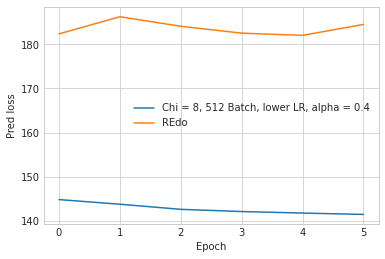

In [ ]:
data = {
    'num_epochs': 6,
    "Chi = 8, 512 Batch, lower LR, alpha = 0.4": chi8_512batch_04alpha,
    "REdo": eval_pred_loss[:6]
}
gen_plot(data, y_label='Pred loss')

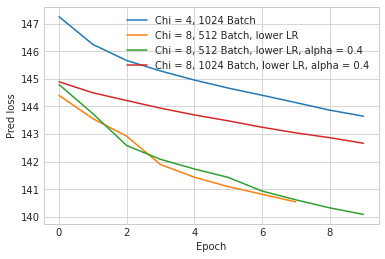

In [ ]:
data = {
    'num_epochs': 10,
    #"IMDb data's best model": imdb_best,
    "Chi = 4, 1024 Batch": yuge_batch,
    "Chi = 8, 512 Batch, lower LR": chi8_512batch,
    "Chi = 8, 512 Batch, lower LR, alpha = 0.4": chi8_512batch_04alpha,
    "Chi = 8, 1024 Batch, lower LR, alpha = 0.4": chi8_1024batch_04alpha,
    #"Chi = 8, 512 Batch, lower LR, alpha = 0.8": chi8_512batch_08alpha,
}
gen_plot(data, y_label='Pred loss')

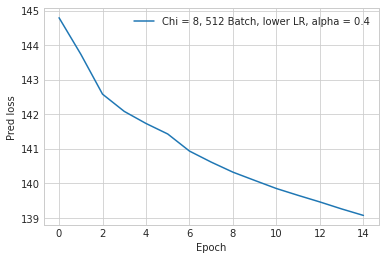

In [ ]:
data_long = {
    'num_epochs': 15,
    "Chi = 8, 512 Batch, lower LR, alpha = 0.4": chi8_512batch_04alpha,
}
gen_plot(data_long, y_label='Pred loss')

In [ ]:
imdb_best = [138.222, 138.77312, 140.64465, 140.07275, 138.7827, 143.901] + 4*[143.901] ## nan for epochs 7 - 10
yuge_batch = [147.2527313232422, 146.24900817871094, 145.6667022705078, 145.28839111328125, 144.9581298828125, 144.66787719726562, 144.40777587890625, 144.14051818847656, 143.86790466308594, 143.64854431152344]
chi8_512batch_04alpha = [144.7936, 143.74002, 142.58311, 142.08423, 141.735, 141.43048, 140.93608, 140.61685, 140.32585, 140.08745, 139.8525, 139.65474, 139.46431, 139.26227, 139.07498]

# IMDb Data graphs

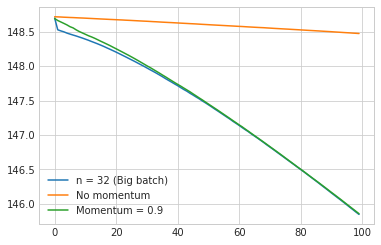

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = list(range(100))
plt.plot(x, big_batch_perf[:100], label="n = 32 (Big batch)")
plt.plot(x, no_mom, label="No momentum")
plt.plot(x, eval_epoch_loss, label="Momentum = 0.9")

plt.legend()

Text(0, 0.5, 'Perplexity')

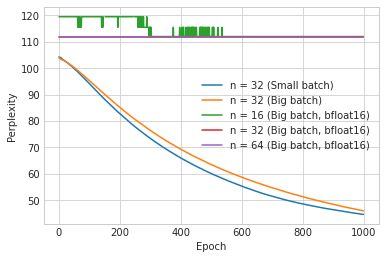

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = list(range(len(no_alpha_eval_loss)))
chi4_small_batch = np.exp(np.asarray(no_alpha_eval_loss)/32)
chi4_big_batch = np.exp(np.asarray(big_batch_perf)/32)
n16_perp = np.exp(np.asarray(n16)/16)
n32_perp = np.exp(np.asarray(n32)/32)
n64_perp = np.exp(np.asarray(n64)/64)
plt.plot(x, chi4_small_batch, label="n = 32 (Small batch)")
plt.plot(x, chi4_big_batch, label="n = 32 (Big batch)")
plt.plot(x, n16_perp, label="n = 16 (Big batch, bfloat16)")
plt.plot(x, n32_perp, label="n = 32 (Big batch, bfloat16)")
plt.plot(x, n64_perp, label="n = 64 (Big batch, bfloat16)")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Perplexity")

Text(0, 0.5, 'Pred Loss')

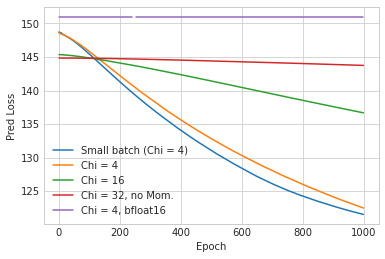

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = list(range(len(no_alpha_eval_loss)))
plt.plot(x, no_alpha_eval_loss, label="Small batch (Chi = 4)")
plt.plot(x, big_batch_perf, label="Chi = 4")
plt.plot(x, chi16, label="Chi = 16")
plt.plot(x, chi32_nomom, label="Chi = 32, no Mom.")
plt.plot(x, chi4_bfloat16, label="Chi = 4, bfloat16")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pred Loss")

Text(0, 0.5, 'Pred Loss')

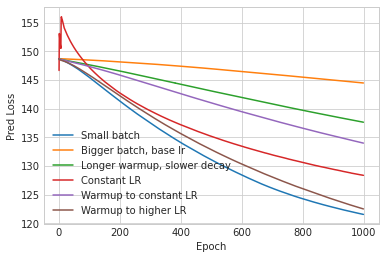

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = list(range(len(no_alpha_eval_loss)))
plt.plot(x, no_alpha_eval_loss, label="Small batch")
plt.plot(x, pseudo_scaled_alpha, label="Bigger batch, base lr")
#plt.plot(x, batch_lr_mk2_eval_loss, label="Bigger batch/lr")  ## same as Mk 6
plt.plot(x, batch_lr_mk3_eval_loss, label="Longer warmup, slower decay")
#plt.plot(x, batch_lr_mk4_eval_loss, label="Base + longer decay delay") ## same as Mk 6
plt.plot(x, batch_lr_mk5_eval_loss, label="Constant LR")
plt.plot(x, batch_lr_mk6_eval_loss, label="Warmup to constant LR")
plt.plot(x, batch_lr_mk7_eval_loss, label="Warmup to higher LR")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pred Loss")

In [ ]:
no_alpha_eval_loss = [148.70663, 148.6864, 148.67332, 148.65022, 148.63824, 148.6243, 148.6031, 148.58635, 148.56071, 148.51889, 148.45544, 148.42964, 148.4067, 148.38261, 148.36023, 148.3374, 148.31427, 148.28978, 148.26482, 148.24022, 148.21474, 148.18896, 148.16373, 148.13728, 148.11053, 148.08423, 148.05812, 148.03088, 148.00198, 147.97319, 147.94594, 147.91707, 147.88663, 147.856, 147.82645, 147.79706, 147.76564, 147.73596, 147.70503, 147.67372, 147.64244, 147.61041, 147.57872, 147.54607, 147.51465, 147.48137, 147.44885, 147.41623, 147.38403, 147.35083, 147.31587, 147.28314, 147.24704, 147.21349, 147.17978, 147.14598, 147.11086, 147.07541, 147.04097, 147.00505, 146.96988, 146.9356, 146.90002, 146.8631, 146.8254, 146.78809, 146.75092, 146.71397, 146.6753, 146.63693, 146.59915, 146.56284, 146.52518, 146.48698, 146.44905, 146.41081, 146.37186, 146.33182, 146.29283, 146.25327, 146.21434, 146.17586, 146.13722, 146.09819, 146.05849, 146.01875, 145.97842, 145.93863, 145.90016, 145.86113, 145.8216, 145.78136, 145.74304, 145.70415, 145.66336, 145.62387, 145.58311, 145.54207, 145.50261, 145.46185, 145.42145, 145.38144, 145.34053, 145.29855, 145.2576, 145.21643, 145.17552, 145.13606, 145.09373, 145.0514, 145.01001, 144.96864, 144.9276, 144.8858, 144.84431, 144.80296, 144.76175, 144.72118, 144.67949, 144.63812, 144.59534, 144.55455, 144.51268, 144.47112, 144.42967, 144.38808, 144.34642, 144.30415, 144.26254, 144.22023, 144.17953, 144.13686, 144.09508, 144.05276, 144.01082, 143.96843, 143.92766, 143.88667, 143.84421, 143.80127, 143.75899, 143.71802, 143.67651, 143.63474, 143.59314, 143.55121, 143.50972, 143.46861, 143.42688, 143.38577, 143.34422, 143.30368, 143.26169, 143.21994, 143.17717, 143.1358, 143.0941, 143.0526, 143.01173, 142.97047, 142.92865, 142.88863, 142.84651, 142.80714, 142.7644, 142.72316, 142.68167, 142.64044, 142.59854, 142.55736, 142.51575, 142.47447, 142.43231, 142.39162, 142.3502, 142.30893, 142.26843, 142.22768, 142.18547, 142.14561, 142.10344, 142.06201, 142.02083, 141.9797, 141.93858, 141.89772, 141.85718, 141.81642, 141.77538, 141.7341, 141.69461, 141.6527, 141.61156, 141.57236, 141.53331, 141.49284, 141.45088, 141.41129, 141.37155, 141.33038, 141.29149, 141.2516, 141.21292, 141.17175, 141.13158, 141.09085, 141.05019, 141.00969, 140.96742, 140.92603, 140.8852, 140.84628, 140.80531, 140.76437, 140.72627, 140.68628, 140.64774, 140.60744, 140.5675, 140.52684, 140.4889, 140.44894, 140.40874, 140.36942, 140.32997, 140.29034, 140.2491, 140.21014, 140.17087, 140.13136, 140.09181, 140.05272, 140.01418, 139.97404, 139.93451, 139.89516, 139.8563, 139.81822, 139.77875, 139.74113, 139.70236, 139.66415, 139.62514, 139.58563, 139.54791, 139.50996, 139.47014, 139.43146, 139.39362, 139.35516, 139.31705, 139.27907, 139.23969, 139.20164, 139.1628, 139.12408, 139.08604, 139.04796, 139.01128, 138.97327, 138.93594, 138.89842, 138.86064, 138.82318, 138.7859, 138.74832, 138.71144, 138.67455, 138.63507, 138.59773, 138.56087, 138.52376, 138.48582, 138.44836, 138.41187, 138.37451, 138.33647, 138.29713, 138.2599, 138.22289, 138.18626, 138.14793, 138.1108, 138.07379, 138.03809, 137.99968, 137.96535, 137.92722, 137.89276, 137.85504, 137.81964, 137.7832, 137.74725, 137.71129, 137.67513, 137.63895, 137.60226, 137.56651, 137.5299, 137.49332, 137.45694, 137.4217, 137.38396, 137.3493, 137.31192, 137.27626, 137.2399, 137.20407, 137.16934, 137.13284, 137.09712, 137.06154, 137.02791, 136.99031, 136.95563, 136.92023, 136.88579, 136.84972, 136.81493, 136.77985, 136.74557, 136.70976, 136.67537, 136.63998, 136.60464, 136.57045, 136.53575, 136.50005, 136.46526, 136.43091, 136.39578, 136.36063, 136.32474, 136.28899, 136.25415, 136.21973, 136.18553, 136.1506, 136.11638, 136.08165, 136.04631, 136.01088, 135.97562, 135.94206, 135.90677, 135.87248, 135.83789, 135.80412, 135.76953, 135.73567, 135.70154, 135.66739, 135.63477, 135.60042, 135.56699, 135.53043, 135.49847, 135.46556, 135.43124, 135.39825, 135.36382, 135.33083, 135.29747, 135.26277, 135.23122, 135.19753, 135.16379, 135.1309, 135.09805, 135.06635, 135.03497, 135.0015, 134.96988, 134.93677, 134.90265, 134.86945, 134.83577, 134.8026, 134.76886, 134.73534, 134.70218, 134.6693, 134.63597, 134.60194, 134.56975, 134.53687, 134.5045, 134.47289, 134.44008, 134.4059, 134.37431, 134.34018, 134.30714, 134.27557, 134.24316, 134.21158, 134.17897, 134.1469, 134.11464, 134.08232, 134.05031, 134.01942, 133.98692, 133.95529, 133.92421, 133.89197, 133.85991, 133.82764, 133.79648, 133.76585, 133.73398, 133.70256, 133.67029, 133.63828, 133.6064, 133.57503, 133.54395, 133.51212, 133.48085, 133.44934, 133.41817, 133.38571, 133.35442, 133.32353, 133.2935, 133.26213, 133.23103, 133.20018, 133.17096, 133.13821, 133.10759, 133.07677, 133.04651, 133.0168, 132.98535, 132.95534, 132.92596, 132.89459, 132.86485, 132.83356, 132.80382, 132.77089, 132.74144, 132.71104, 132.68147, 132.65207, 132.62117, 132.59158, 132.56172, 132.53223, 132.50156, 132.47258, 132.44139, 132.412, 132.38191, 132.35194, 132.3217, 132.29182, 132.2623, 132.23297, 132.20425, 132.17569, 132.14697, 132.11778, 132.08954, 132.05891, 132.02983, 132.00209, 131.9726, 131.94244, 131.9137, 131.88422, 131.85509, 131.82582, 131.7971, 131.76823, 131.74019, 131.71031, 131.67923, 131.64992, 131.62134, 131.59033, 131.56161, 131.53282, 131.50322, 131.47574, 131.44678, 131.42032, 131.39114, 131.36226, 131.33339, 131.30626, 131.27869, 131.24976, 131.22183, 131.19435, 131.16469, 131.13731, 131.10938, 131.0803, 131.05064, 131.0235, 130.99364, 130.96494, 130.93787, 130.90901, 130.88347, 130.8533, 130.82578, 130.79889, 130.77112, 130.74332, 130.71458, 130.68591, 130.65962, 130.63127, 130.6021, 130.57542, 130.54865, 130.52051, 130.49358, 130.46477, 130.43845, 130.4105, 130.38313, 130.35608, 130.32898, 130.30176, 130.27538, 130.24756, 130.22028, 130.19354, 130.16606, 130.1392, 130.11238, 130.08563, 130.05893, 130.03215, 130.00517, 129.97801, 129.95088, 129.92424, 129.89848, 129.87318, 129.84514, 129.82082, 129.79399, 129.76811, 129.74155, 129.71577, 129.6888, 129.66165, 129.63606, 129.61084, 129.58328, 129.55779, 129.53229, 129.50687, 129.48083, 129.45288, 129.42697, 129.40117, 129.3742, 129.34706, 129.32104, 129.29347, 129.26685, 129.24077, 129.21432, 129.18971, 129.16432, 129.13858, 129.1118, 129.08656, 129.06137, 129.03485, 129.00896, 128.98311, 128.95792, 128.93225, 128.90663, 128.88116, 128.8549, 128.82933, 128.80458, 128.78004, 128.75412, 128.72888, 128.7035, 128.67844, 128.65407, 128.62877, 128.60385, 128.5794, 128.5541, 128.52902, 128.50374, 128.47841, 128.45311, 128.42865, 128.4038, 128.37936, 128.35283, 128.32811, 128.30386, 128.27832, 128.2537, 128.22989, 128.20544, 128.17993, 128.155, 128.13107, 128.1056, 128.07959, 128.05455, 128.02954, 128.00587, 127.98075, 127.9546, 127.93103, 127.90667, 127.88314, 127.85723, 127.833115, 127.809204, 127.784065, 127.759514, 127.73542, 127.71197, 127.68842, 127.66438, 127.63896, 127.6146, 127.590965, 127.566475, 127.54288, 127.51927, 127.49593, 127.471275, 127.44657, 127.42216, 127.39801, 127.37456, 127.35093, 127.3266, 127.30348, 127.2806, 127.25709, 127.23323, 127.20984, 127.18552, 127.16293, 127.14043, 127.117645, 127.09368, 127.06977, 127.04792, 127.02477, 127.0026, 126.97841, 126.95598, 126.93287, 126.91019, 126.88586, 126.8636, 126.84078, 126.81845, 126.796234, 126.77382, 126.75228, 126.73025, 126.70789, 126.6864, 126.66506, 126.64402, 126.62247, 126.60198, 126.58116, 126.560135, 126.53802, 126.51533, 126.49353, 126.47151, 126.45117, 126.42927, 126.40926, 126.38794, 126.36644, 126.3456, 126.32364, 126.30417, 126.28195, 126.2631, 126.242836, 126.22167, 126.1995, 126.180305, 126.158295, 126.13794, 126.116264, 126.09595, 126.07423, 126.054146, 126.03349, 126.013214, 125.99323, 125.972404, 125.9514, 125.93162, 125.91054, 125.889915, 125.86969, 125.84967, 125.829605, 125.809616, 125.78888, 125.76925, 125.74993, 125.73069, 125.71106, 125.691765, 125.67213, 125.652725, 125.632515, 125.61326, 125.59439, 125.57497, 125.55551, 125.53656, 125.51707, 125.497475, 125.47836, 125.45904, 125.43924, 125.420074, 125.40154, 125.38313, 125.36324, 125.343834, 125.32489, 125.30541, 125.28582, 125.26709, 125.248825, 125.23001, 125.21148, 125.192184, 125.17326, 125.154976, 125.13716, 125.11891, 125.10106, 125.082596, 125.065186, 125.0471, 125.02945, 125.01083, 124.99279, 124.97438, 124.95732, 124.93863, 124.92085, 124.903824, 124.88594, 124.86817, 124.85064, 124.834915, 124.815704, 124.79892, 124.78104, 124.76194, 124.746635, 124.72708, 124.711044, 124.69349, 124.67527, 124.65683, 124.639565, 124.62184, 124.60348, 124.58875, 124.572136, 124.554306, 124.5357, 124.51868, 124.5025, 124.485214, 124.46752, 124.45098, 124.434975, 124.41907, 124.40216, 124.38578, 124.36981, 124.35272, 124.33616, 124.32041, 124.30337, 124.28936, 124.27308, 124.25702, 124.239525, 124.223595, 124.207535, 124.19032, 124.17406, 124.15563, 124.139755, 124.125824, 124.11044, 124.094475, 124.07838, 124.06204, 124.046135, 124.03057, 124.01392, 123.997734, 123.9802, 123.96476, 123.94839, 123.93043, 123.91454, 123.90008, 123.88354, 123.868126, 123.85239, 123.83724, 123.8209, 123.80654, 123.79091, 123.77604, 123.75992, 123.74479, 123.72926, 123.71285, 123.698105, 123.68386, 123.66961, 123.65468, 123.638084, 123.62273, 123.607864, 123.59257, 123.57998, 123.56536, 123.55028, 123.53454, 123.51821, 123.5033, 123.48744, 123.47243, 123.458466, 123.444534, 123.43027, 123.41415, 123.3994, 123.38387, 123.369385, 123.3552, 123.340385, 123.32516, 123.309654, 123.29575, 123.28217, 123.26816, 123.253235, 123.2389, 123.22336, 123.20793, 123.19304, 123.17722, 123.16323, 123.15009, 123.13716, 123.12278, 123.10876, 123.09456, 123.080826, 123.06752, 123.05204, 123.03822, 123.02432, 123.0104, 122.99657, 122.98269, 122.96759, 122.95351, 122.93936, 122.92748, 122.91431, 122.9005, 122.88694, 122.87347, 122.859604, 122.84548, 122.83264, 122.819725, 122.80587, 122.79303, 122.77919, 122.766624, 122.7524, 122.738785, 122.7248, 122.7118, 122.696815, 122.68359, 122.66913, 122.65612, 122.64121, 122.627556, 122.617195, 122.60261, 122.58918, 122.57604, 122.563705, 122.54882, 122.53464, 122.52334, 122.51079, 122.49772, 122.48355, 122.4702, 122.45774, 122.44384, 122.430046, 122.416824, 122.40379, 122.39158, 122.378006, 122.365234, 122.353325, 122.33835, 122.325745, 122.31206, 122.29906, 122.28647, 122.274536, 122.26216, 122.24962, 122.23579, 122.22378, 122.210594, 122.19785, 122.18565, 122.173004, 122.16099, 122.148315, 122.13524, 122.122475, 122.11015, 122.09768, 122.08497, 122.07216, 122.05981, 122.048775, 122.03471, 122.02255, 122.01009, 121.9973, 121.98606, 121.97393, 121.96192, 121.94941, 121.93908, 121.92608, 121.91432, 121.902626, 121.8906, 121.87855, 121.8663, 121.85435, 121.84109, 121.83135, 121.82099, 121.80878, 121.79541, 121.78359, 121.77187, 121.75976, 121.748474, 121.737, 121.72507, 121.71366, 121.70325, 121.69138, 121.6796, 121.66966, 121.65663, 121.64542, 121.63214, 121.61879, 121.60473, 121.59661, 121.584114, 121.57338, 121.56236, 121.55034, 121.53866, 121.526764]

big_batch_perf = [148.69579, 148.52623, 148.51018, 148.4965, 148.47801, 148.46358, 148.44958, 148.4362, 148.42122, 148.40645, 148.39021, 148.37404, 148.3561, 148.3393, 148.32182, 148.30316, 148.2842, 148.26343, 148.24352, 148.22284, 148.20201, 148.17998, 148.15764, 148.13568, 148.11284, 148.09026, 148.06772, 148.0442, 148.02063, 147.99733, 147.97276, 147.94774, 147.92406, 147.89919, 147.8733, 147.8473, 147.8195, 147.79333, 147.76785, 147.74115, 147.71585, 147.6875, 147.66002, 147.63544, 147.60594, 147.57953, 147.55159, 147.5252, 147.49504, 147.46797, 147.43889, 147.40952, 147.37895, 147.34998, 147.32011, 147.29039, 147.26025, 147.23102, 147.19838, 147.16934, 147.13905, 147.10747, 147.07726, 147.04854, 147.01506, 146.98492, 146.95465, 146.92294, 146.89078, 146.85728, 146.82582, 146.79428, 146.76122, 146.72847, 146.6961, 146.66342, 146.63062, 146.59807, 146.56604, 146.53284, 146.5003, 146.46826, 146.43402, 146.40045, 146.36671, 146.33315, 146.2989, 146.26387, 146.22986, 146.19563, 146.16022, 146.12627, 146.09193, 146.05835, 146.02342, 145.98833, 145.95258, 145.91798, 145.88243, 145.8483, 145.8131, 145.77747, 145.742, 145.70709, 145.67285, 145.63841, 145.60316, 145.56807, 145.53326, 145.49873, 145.46318, 145.42828, 145.39275, 145.35684, 145.32185, 145.28563, 145.25035, 145.21509, 145.1783, 145.14238, 145.10597, 145.06969, 145.03564, 144.99918, 144.96455, 144.92888, 144.89336, 144.85779, 144.82147, 144.78581, 144.7489, 144.71268, 144.6764, 144.64246, 144.60628, 144.56998, 144.53444, 144.4973, 144.46187, 144.42558, 144.38995, 144.35396, 144.31947, 144.28377, 144.24599, 144.20992, 144.17325, 144.13693, 144.10085, 144.06549, 144.02875, 143.99234, 143.95454, 143.91847, 143.88116, 143.8444, 143.80739, 143.7704, 143.73398, 143.69658, 143.66048, 143.62373, 143.58746, 143.55107, 143.51605, 143.4791, 143.44276, 143.40723, 143.37022, 143.33519, 143.29982, 143.26259, 143.22684, 143.19054, 143.15448, 143.11859, 143.08266, 143.04631, 143.01035, 142.97464, 142.93793, 142.9009, 142.86446, 142.82816, 142.79337, 142.75719, 142.72105, 142.68257, 142.64607, 142.6095, 142.57321, 142.53822, 142.50188, 142.46596, 142.42906, 142.3935, 142.35591, 142.31917, 142.28377, 142.24658, 142.2096, 142.17291, 142.13629, 142.10088, 142.06398, 142.02888, 141.99281, 141.95683, 141.91963, 141.8848, 141.84901, 141.81348, 141.77821, 141.74254, 141.70653, 141.6703, 141.63435, 141.59914, 141.56432, 141.52916, 141.49426, 141.4584, 141.42264, 141.38725, 141.3513, 141.31657, 141.28114, 141.24646, 141.21065, 141.17522, 141.14014, 141.10516, 141.0711, 141.03564, 141.00084, 140.96495, 140.92964, 140.89536, 140.85976, 140.82402, 140.7898, 140.75433, 140.71948, 140.68393, 140.64992, 140.61482, 140.57994, 140.54573, 140.51129, 140.47589, 140.44112, 140.40753, 140.37267, 140.33801, 140.30394, 140.26923, 140.23305, 140.19904, 140.16441, 140.13135, 140.09608, 140.06238, 140.0277, 139.9922, 139.9579, 139.92395, 139.88933, 139.85457, 139.82059, 139.78667, 139.75362, 139.7199, 139.68544, 139.65163, 139.61766, 139.583, 139.54811, 139.51494, 139.482, 139.44849, 139.41371, 139.38011, 139.34671, 139.31339, 139.28014, 139.24693, 139.21317, 139.17894, 139.14479, 139.11206, 139.0785, 139.04427, 139.01178, 138.97899, 138.94637, 138.91325, 138.88065, 138.84673, 138.81403, 138.78102, 138.74817, 138.71544, 138.68256, 138.64865, 138.61449, 138.5801, 138.54744, 138.51453, 138.4814, 138.44887, 138.41518, 138.38176, 138.34721, 138.31398, 138.28111, 138.24901, 138.2163, 138.1837, 138.15158, 138.11931, 138.08702, 138.05591, 138.02269, 137.99036, 137.95784, 137.9262, 137.89534, 137.86293, 137.83116, 137.79897, 137.76692, 137.73485, 137.70311, 137.67126, 137.63896, 137.60742, 137.57503, 137.54291, 137.51076, 137.47691, 137.44568, 137.41502, 137.38208, 137.35004, 137.31795, 137.28592, 137.25455, 137.2231, 137.19197, 137.16115, 137.12897, 137.09784, 137.06879, 137.03748, 137.00526, 136.97469, 136.94452, 136.91331, 136.88237, 136.8521, 136.82108, 136.78996, 136.76064, 136.72884, 136.69786, 136.66675, 136.63754, 136.60687, 136.57494, 136.5451, 136.51312, 136.48413, 136.45401, 136.42207, 136.3922, 136.36111, 136.33081, 136.30243, 136.27042, 136.24022, 136.21094, 136.17905, 136.15071, 136.12196, 136.09149, 136.06189, 136.0323, 136.00177, 135.97221, 135.94183, 135.911, 135.88179, 135.85214, 135.82251, 135.79189, 135.76295, 135.73352, 135.70271, 135.67316, 135.64418, 135.61482, 135.58469, 135.55495, 135.52544, 135.49593, 135.46553, 135.43573, 135.40579, 135.37592, 135.34727, 135.31757, 135.28877, 135.26009, 135.22987, 135.20027, 135.17163, 135.14189, 135.1127, 135.08408, 135.05519, 135.02583, 134.99696, 134.96756, 134.93968, 134.91206, 134.88374, 134.85365, 134.82384, 134.79597, 134.76753, 134.73769, 134.71046, 134.68178, 134.65427, 134.62587, 134.59741, 134.56853, 134.5407, 134.51256, 134.4836, 134.45457, 134.4273, 134.39915, 134.37108, 134.3429, 134.3144, 134.28462, 134.25671, 134.22832, 134.20064, 134.17201, 134.14444, 134.11638, 134.08891, 134.06151, 134.03447, 134.00615, 133.97844, 133.95128, 133.92311, 133.89565, 133.86842, 133.84021, 133.81306, 133.78593, 133.75972, 133.73177, 133.70433, 133.6772, 133.64946, 133.62207, 133.59447, 133.56685, 133.5389, 133.51308, 133.48457, 133.4574, 133.4302, 133.4033, 133.37567, 133.3492, 133.32243, 133.29488, 133.26791, 133.24043, 133.2133, 133.18672, 133.15991, 133.13309, 133.1061, 133.07964, 133.05263, 133.02596, 132.99919, 132.9729, 132.94672, 132.91924, 132.89357, 132.86679, 132.83932, 132.81195, 132.7846, 132.7578, 132.73128, 132.70622, 132.67955, 132.65369, 132.62798, 132.60143, 132.57556, 132.54962, 132.52303, 132.49654, 132.47142, 132.44429, 132.41911, 132.39485, 132.3687, 132.3423, 132.31622, 132.29051, 132.2633, 132.23817, 132.2129, 132.18681, 132.16074, 132.13539, 132.10936, 132.0837, 132.06018, 132.03523, 132.00897, 131.98293, 131.95776, 131.9326, 131.9074, 131.88222, 131.85704, 131.83232, 131.80782, 131.78154, 131.7564, 131.73047, 131.70535, 131.67903, 131.65399, 131.62854, 131.60092, 131.575, 131.5494, 131.52446, 131.50092, 131.47633, 131.45097, 131.42503, 131.40123, 131.37727, 131.3509, 131.3256, 131.30034, 131.27507, 131.25075, 131.226, 131.20149, 131.17717, 131.153, 131.12785, 131.1034, 131.07845, 131.05424, 131.02924, 131.00533, 130.98077, 130.95583, 130.93147, 130.90706, 130.8831, 130.85774, 130.83522, 130.80968, 130.78514, 130.7608, 130.73672, 130.71263, 130.68867, 130.6657, 130.64146, 130.61748, 130.59402, 130.5699, 130.54712, 130.52306, 130.49953, 130.47588, 130.45256, 130.42897, 130.4049, 130.38164, 130.35793, 130.333, 130.30888, 130.28484, 130.26202, 130.23686, 130.21278, 130.18916, 130.16585, 130.14145, 130.11734, 130.09303, 130.06912, 130.0447, 130.02237, 129.99998, 129.976, 129.95277, 129.92918, 129.90515, 129.88174, 129.85802, 129.8354, 129.81206, 129.78941, 129.76602, 129.74287, 129.71967, 129.69661, 129.67238, 129.64864, 129.62576, 129.60254, 129.58006, 129.55678, 129.53424, 129.51039, 129.48763, 129.46458, 129.4394, 129.41759, 129.39372, 129.37044, 129.34906, 129.32512, 129.30241, 129.27905, 129.2567, 129.23413, 129.21274, 129.19115, 129.16846, 129.1465, 129.1236, 129.10107, 129.07826, 129.05644, 129.03322, 129.01094, 128.98906, 128.9664, 128.9453, 128.92308, 128.90132, 128.87898, 128.85771, 128.8343, 128.81133, 128.78957, 128.76723, 128.74452, 128.72133, 128.69872, 128.67657, 128.6533, 128.63118, 128.60948, 128.5873, 128.56453, 128.54259, 128.52069, 128.4984, 128.47636, 128.45384, 128.43211, 128.4124, 128.39034, 128.37036, 128.34895, 128.32652, 128.30411, 128.28322, 128.26158, 128.24043, 128.21918, 128.1978, 128.17516, 128.1548, 128.13295, 128.11107, 128.0902, 128.06776, 128.046, 128.02522, 128.00372, 127.98281, 127.961464, 127.93905, 127.91805, 127.89685, 127.87505, 127.854164, 127.832115, 127.810425, 127.78901, 127.76833, 127.74575, 127.72671, 127.70343, 127.68209, 127.66195, 127.64001, 127.618835, 127.598045, 127.57668, 127.55741, 127.53479, 127.51404, 127.49218, 127.47116, 127.451, 127.43046, 127.40981, 127.38914, 127.368095, 127.34723, 127.3269, 127.30615, 127.28528, 127.26565, 127.245544, 127.22473, 127.20388, 127.1839, 127.16453, 127.14416, 127.12204, 127.100525, 127.08036, 127.05902, 127.03843, 127.018555, 126.99762, 126.97644, 126.95581, 126.9349, 126.91349, 126.89333, 126.87339, 126.852844, 126.83256, 126.81234, 126.79264, 126.772064, 126.75063, 126.72996, 126.71011, 126.69053, 126.67089, 126.65151, 126.6319, 126.61145, 126.59137, 126.571266, 126.54996, 126.52958, 126.50946, 126.488014, 126.469635, 126.449005, 126.43002, 126.41105, 126.38949, 126.36975, 126.350624, 126.33108, 126.310425, 126.2913, 126.27131, 126.252785, 126.23173, 126.21225, 126.19263, 126.1745, 126.151024, 126.13153, 126.11261, 126.093834, 126.0743, 126.05607, 126.03484, 126.01572, 125.99598, 125.97958, 125.95927, 125.940346, 125.92005, 125.90112, 125.88275, 125.86313, 125.84283, 125.823456, 125.804115, 125.783966, 125.76462, 125.74636, 125.727356, 125.70907, 125.69004, 125.671, 125.650505, 125.63403, 125.61541, 125.59625, 125.57705, 125.55844, 125.53943, 125.51998, 125.50111, 125.48182, 125.46273, 125.443794, 125.424164, 125.40438, 125.38558, 125.36721, 125.348114, 125.3287, 125.30898, 125.29003, 125.27102, 125.25283, 125.23407, 125.21525, 125.19746, 125.17809, 125.159645, 125.14121, 125.12296, 125.105286, 125.086784, 125.06885, 125.04932, 125.0319, 125.01302, 124.99564, 124.976135, 124.95828, 124.940285, 124.91979, 124.902016, 124.88346, 124.86556, 124.84845, 124.830666, 124.81079, 124.79297, 124.7738, 124.757256, 124.73764, 124.719, 124.70225, 124.68455, 124.6665, 124.64951, 124.63166, 124.61292, 124.594604, 124.576515, 124.55857, 124.54061, 124.522766, 124.50436, 124.48722, 124.46991, 124.45072, 124.432106, 124.41566, 124.39758, 124.37902, 124.36161, 124.343956, 124.32534, 124.306206, 124.28797, 124.27056, 124.25189, 124.23472, 124.216545, 124.19991, 124.18136, 124.1629, 124.14737, 124.129456, 124.11167, 124.09292, 124.07581, 124.0579, 124.03915, 124.022095, 124.00388, 123.98639, 123.96876, 123.95162, 123.93363, 123.91739, 123.90037, 123.882225, 123.86451, 123.84611, 123.8291, 123.81152, 123.79407, 123.776726, 123.75947, 123.74249, 123.724495, 123.70694, 123.689674, 123.67218, 123.65582, 123.63883, 123.62085, 123.603065, 123.58581, 123.568565, 123.55194, 123.535675, 123.5187, 123.50201, 123.48638, 123.46923, 123.45231, 123.43447, 123.41732, 123.4004, 123.38326, 123.36664, 123.34908, 123.33314, 123.31546, 123.300606, 123.281586, 123.2647, 123.24801, 123.23136, 123.214516, 123.19803, 123.18284, 123.16525, 123.14901, 123.13269, 123.11532, 123.09844, 123.082664, 123.066475, 123.05071, 123.03421, 123.01754, 122.99978, 122.984436, 122.96789, 122.95219, 122.93747, 122.919975, 122.90405, 122.88739, 122.86991, 122.854034, 122.83743, 122.82117, 122.806984, 122.79049, 122.77451, 122.75855, 122.74249, 122.72601, 122.710686, 122.69381, 122.67633, 122.66077, 122.64411, 122.62716, 122.611275, 122.59573, 122.57992, 122.56373, 122.54815, 122.53241, 122.515175, 122.499275, 122.48348]

Text(0, 0.5, 'Pred Loss')

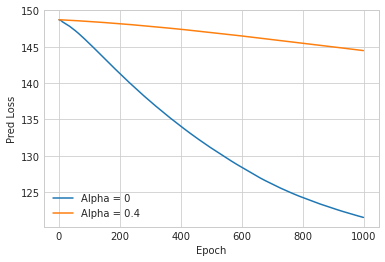

In [ ]:
start_match = no_alpha_eval_loss[0] - alpha_eval_loss[0]
pseudo_scaled_alpha = [i+start_match for i in alpha_eval_loss] #Diff in norm over 1000 Epochs is 0.09, so this is a good approx.

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

x = list(range(len(no_alpha_eval_loss)))
plt.plot(x, no_alpha_eval_loss, label="Alpha = 0")
plt.plot(x, pseudo_scaled_alpha, label="Alpha = 0.4")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Pred Loss")

Epoch 1000 Eval: loss: 258.96; pred_loss: 144.52; log_norm_sq: 286.10;

Total runtime: 2118.05 sec, (0.59 hours)

*Alpha = 0.4*:

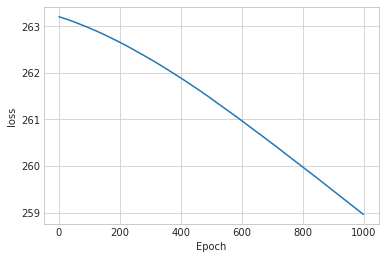

In [ ]:
gen_plot(eval_epoch_loss)

Epoch 1000 Eval: loss: 121.53; log_norm_sq: 286.20

Total runtime: 9168.76 sec, (2.55 hours)

*Parallel + Fix norm param grad*:

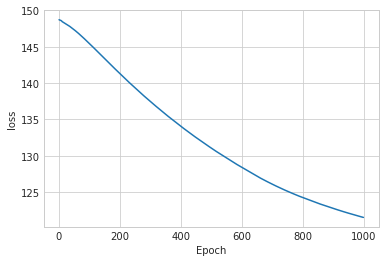

In [ ]:
gen_plot(eval_epoch_loss)

Epoch 1000 Eval: loss: 122.23; log_norm_sq: 291.80

Total runtime: 5769.71 sec, (1.60 hours)

*Learning rate schedule*:

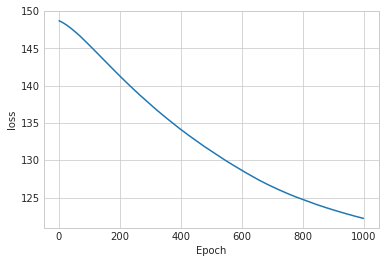

In [ ]:
gen_plot(eval_epoch_loss)

Epoch 1000 Eval: loss: 121.88; log_norm_sq: 300.74

Total runtime: 5926.77 sec, (1.65 hours)

*No log norm squared in loss*:

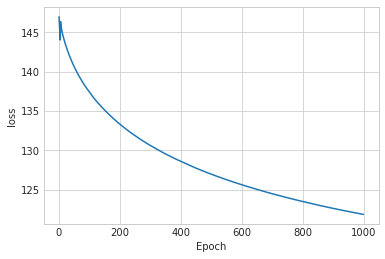

In [ ]:
gen_plot(eval_epoch_loss)

In [ ]:
save_file(train_epoch_loss, 'train_epoch_data_save.pkl')
save_file(eval_epoch_loss, 'eval_epoch_data_save.pkl')

# Tests

In [ ]:
## Check initial MPS norm

#shapes = jax.tree_map(lambda x: x.shape, state.params)
#print(shapes)
print("Word 0 Core:", state.params['core_0']['embedding'])
for partial_len in [1,2,4,8]:
  t0 = time.time()
  norm = mps_norm(state.params, max_seq_len, partial_len)
  dur = time.time() - t0
  print("Norm", norm, "time", dur)

Word 0 Core: [[ 0.2224801  -0.36667657  0.72352356 ...  0.0716764  -0.02004405
  -0.20560369]
 [-0.0444713  -0.21846372 -1.2551806  ...  0.17329124  0.13092515
   0.38855588]
 [ 0.00800424  0.721107   -0.39009124 ...  0.23135054  0.2118913
  -0.36881104]
 ...
 [ 0.05510289 -0.5349652  -0.6614051  ...  0.1269849  -0.2827142
   0.6106043 ]
 [-0.30168432  0.4404104   0.18174013 ...  0.32294422  0.28978056
   0.07962409]
 [ 0.30488154 -0.6382386  -0.05592541 ... -0.52194226  0.02413949
  -0.24835804]]
Norm 662.57294 time 0.11931777000427246
Norm 662.57367 time 0.11051440238952637
Norm 662.57684 time 0.10874080657958984
Norm nan time 0.10677766799926758


In [ ]:
test_batch = train_ds[:2]
print(test_batch)

probs = state.apply_fn({'params': state.params}, test_batch)
print("probs", probs)
loss = logprob_loss(probs)
print("loss", loss)

def loss_fn(params):
  probs = state.apply_fn({'params': params}, test_batch)
  loss = logprob_loss(probs)
  return loss, probs
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
(_, probs), grads = grad_fn(state.params)
print("grads", grads)
#state = state.apply_gradients(grads=grads)
metrics = compute_metrics(probs)
print("loss", metrics['loss'], "acc", metrics['confidence'])

print("train step", train_step(state, test_batch))

[[ 62  18  41 604]
 [ 12  31  93 867]]
probs [5.0324456e-09 5.0612718e-09           nan]


TypeError: ignored

## Numerical Stability

In [ ]:
## Params

n=64
vocab = 32
bond_dim=16
verbose = False
key = jax.random.PRNGKey(16)

In [ ]:
## Find init scale attempt 1: Cardano formula of cubic
alpha = 2 * (bond_dim**3) * (vocab**(4*n))
print("alpha",alpha)
beta = bond_dim*(1-2*(vocab**(2*n)))
print("beta", beta)
delta = np.sqrt(1/(4*alpha**2) + ((beta/alpha)**3)/27)
print("delta", delta)
norm_fac_p = np.power(1/(2*alpha) + delta, 6*n)
norm_fac_m = np.power(1/(2*alpha) - delta, 6*n)
print("norm+", norm_fac_p, " norm-", norm_fac_m)

alpha 19745279401337098965648315236583949212975867887171083889538457920022588551920051819881144517487378838842972293373034535222168919890288298598151069596801225944721107676214273841322246782301646845352718689381481021911837457267954475904707683304239169249262105733876127151140645726467009973549417791224101850074062594942743281197500268638722117223060107983674580940512397586240689202638971402689522689493078067175365328066199314534611708513494900628332582996699682701312
beta -49680578953622685924767343630800081768220352547734291556449665216833630485964060362588109082516687294415607382308194342597490561411674060526217192801317796454542559232667196977608489140211150234408415974198927000028571099322113851376
delta 0.0
norm+ 0.0  norm- 0.0


In [ ]:
def scale_fac(n, chi, c, k):
  alpha = 2 * (chi**3) * (n**(4*c))
  beta = chi*(1-2*(n**(2*c)))

  p = beta/alpha
  q = -1/alpha

  x = 2*np.sqrt(-p/3)*np.cos(np.arccos( (3*q/(2*p)) * np.sqrt(-3/p) )/3 - 2*np.pi*k/3)

  return np.power(x, 1/(2*c))

In [ ]:
for k in range(3):
  print(f"k = {k}:", scale_fac(vocab, bond_dim, n, k))

k = 0: 0.172988735245479
k = 1: 0.12937240550816467
k = 2: nan


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_tpu_dd_constantijnvdp.kernel.constantijnvdp.4520423659676.14b334fb3717c109/mount/server/ml_notebook:10: RuntimeWarning: invalid value encountered in power


In [ ]:
a = scale_fac(vocab, bond_dim, n, 0)
#a = np.power(vocab, (1-4*n)/(4*n))

print(a)

0.172988735245479


In [ ]:
## Build cores

core_list=[]
for i in range(n):
  word_core = jnp.eye(bond_dim) * a
  '''
  key = jax.random.PRNGKey(i)
  word_core = random.normal(key, (bond_dim**2,))
  '''
  '''
  key = jax.random.PRNGKey(i)
  word_core, _ = jnp.linalg.qr(random.normal(key, 2*(bond_dim,)))
  '''
  core = jnp.zeros((vocab, bond_dim**2)) + word_core.flatten()
  core_list.append(core)

In [ ]:
## Play with initialization to get close to unit norm

phys_contr=[]
for core in core_list:
  if verbose: print("core\n", core)
  ## contract over physical dimension
  phys = jnp.matmul(core.T, core)
  if verbose: print("phys contr\n", phys)
  """ the indices are a top bond_dim^2, and a bottom bond_dim^2
      split each into a left and a right,
      move the lefts next to each other, idem for the rights,
      then merge the lefts and merge the rights """
  reshaped_core = phys.reshape(4*(bond_dim,)).transpose(0,2,1,3).reshape(2*(bond_dim**2,)) 
  if verbose: print("reshaped\n", reshaped_core, '\n')
  phys_contr.append(reshaped_core)

compact = contract_cores(phys_contr)
if verbose: print("compact\n", compact, "\n")
norm = jnp.abs(jnp.trace(jnp.matmul(compact.T, compact)))
print('Test Norm:', norm)

Test Norm: 0.99220276


In [ ]:
## Play with MPS-seq contraction

## Generate list of word cores (batch size = 1)
contr_cores = []
for core in core_list:
  word_core = core[0].reshape(bond_dim, bond_dim)
  if verbose: print("word core\n", word_core)
  contr_cores.append(word_core)

## Contract cores
while len(contr_cores) > 1:
    #contr_cores = [jnp.matmul(contr_cores[i], contr_cores[i+1]) for i in range(0, len(contr_cores), 2)]
    Lcore = contr_cores.pop(0)
    if verbose: print("Lcore\n", Lcore)
    contr_cores[0] = jnp.matmul(Lcore, contr_cores[0])
contracted_list = contr_cores[0]

## Apply boundary conditions
compact = contracted_list/vocab
if verbose: print("compact\n", compact, "\n")

output = jnp.abs( jnp.trace(jnp.matmul(compact.T, compact)) )
print("Output", output)
print("\n      Prob", np.exp(np.log(output)-np.log(norm)))
print("a = 1 Prob", 1/(bond_dim * vocab**(2*n)) )

In [ ]:
## Sanity check prob estimate
1/(bond_dim * vocab**(2*n) * a**(2*n))

4.681676354692169e-97